# Dealing with filter uncertainty and underdetermined systems

In this tutorial, we will go through some of the basics of dealing with underdetermined system and uncertainty regarding the receptor filters. We will work with the same example from the introduction. However, this time we will also define the uncertainty around our actual filter function (i.e. the standard deviation around the mean filter array).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns

import dreye

In [2]:
filters_colors = ['gray', 'black']
sources_colors = ['violet', 'cyan', 'green']

# wavelength range
wls = np.arange(300, 700, 1)
# peaks of the sensitivities
peaks = np.array([420, 535])
# opsin template
# an empty axis is added to the peaks so that the array object has dimension (opsin_type x wavelengths)
filters = dreye.govardovskii2000_template(wls, peaks[:, None])

led_peaks = np.array([410, 480, 550])
sources = norm.pdf(wls, loc=led_peaks[:, None], scale=20)
sources = sources / dreye.integral(sources, wls, axis=-1, keepdims=True)

est = dreye.ReceptorEstimator(
    # filters array
    filters, 
    ### ADDING FILTER UNCERTAINTY
    ### In this case it scales with the value of the filter function (heteroscedastic)
    filters_uncertainty=filters * 0.1,
    # wavelength array
    domain=wls, 
    # labels for each photoreceptor type (optional)
    labels=['S', 'L'], 
    # LED array, optional
    sources=sources, 
    # lower bound of each LED, optional
    lb=np.zeros(3), 
    # upper bound for each LED, optional - if None, then the upper bound is infinity
    ub=np.ones(3) * 0.1, 
    # labels for sources, optional
    sources_labels=['V', 'C', 'G'], 
    baseline=1e-3
)

# setting K according to intensities of our sources
source_bg = np.array([0.01, 0.015, 0.018])
est.register_system_adaptation(source_bg)

The attribute `Epsilon` defines the variance in capture for each source and filter. `A` defines the mean light-induced capture for each source and filter.

<Axes: >

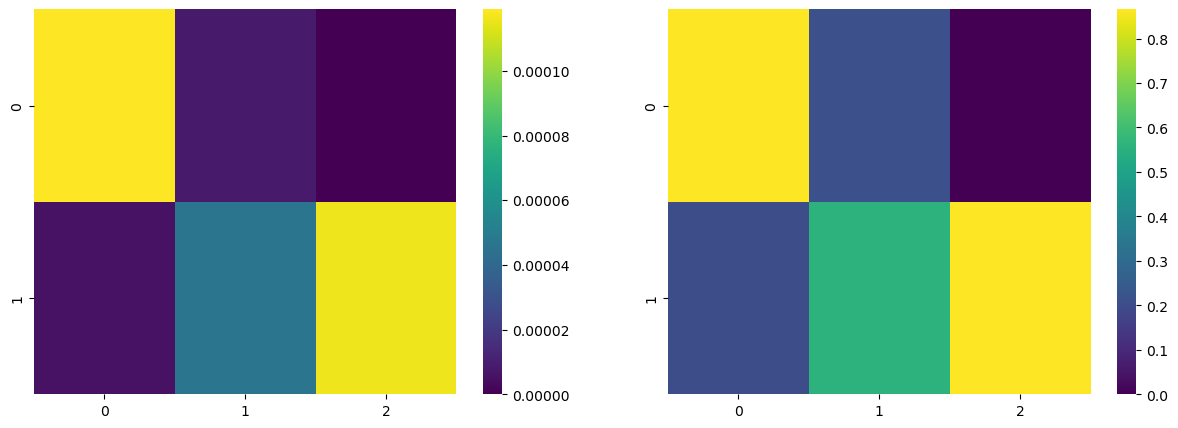

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(
    est.Epsilon, ax=ax1, 
    vmin=0, cmap='viridis'
)
sns.heatmap(
    est.A, ax=ax2,
    vmin=0, cmap='viridis' 
)

## Underdetermined System

Since this is an underdetermined system (more sources than filters), there can exist multiple solutions for fitting to capture values that are within the gamut of the system. Let's first sample points within the gamut of the system.

Iterations: 100%|██████████| 4/4 [00:00<00:00, 319.21it/s]


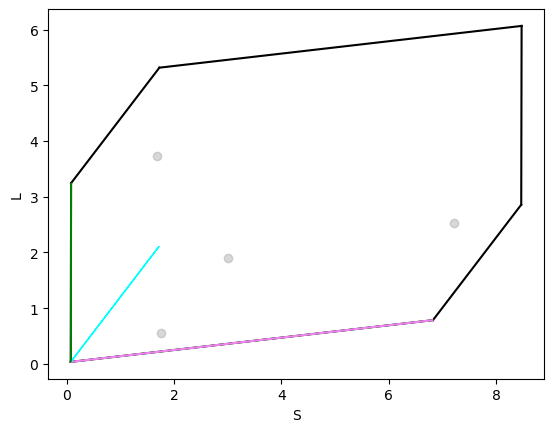

In [4]:
# Fitting with some points outside the hull
B = est.sample_in_hull(4, seed=2)

# Fitting points
Xhat, Bhat = est.fit(B, verbose=1)

fig, axes = est.gamut_plot(B, colors=sources_colors, c='gray', alpha=0.3)

Using the `range_of_solutions` method we can find the range of solutions that fit each of these five examples.

In [5]:
xmin, xmax = est.range_of_solutions(B)

# if we specificy a number of points that we want within that range the function also returns those intensities for our LEDs
xmin, xmax, X = est.range_of_solutions(B, n=10)
X = np.stack(X)

# for each of our five samples we have ten intensity combinations that are evenly space along the n
print(X.shape)

(4, 10, 3)


For each of our five samples we have ten intensity combinations that are evenly spaced along the line of possible solutions. But which intensity set should we choose for each of our five samples? In this case, we may wish to choose a set of intensities that minimizes the expected variance in the capture values given our uncertainty of our filter functions. To do this, we can use the `minimize_variance` method. NB: This method generally works well if the system is underdetermined and the points lie within the gamut of the system. Otherwise, it does not make much sense to use this method.

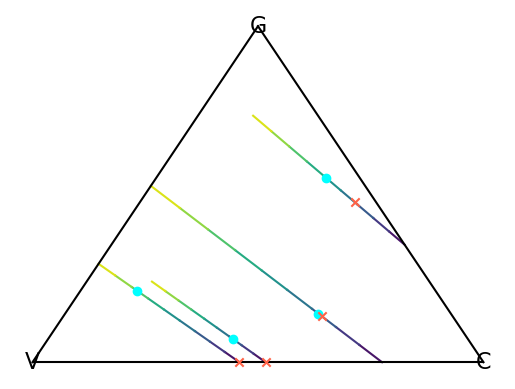

In [6]:
# the last object returned is the variance in the capture, which we will ignore for now.
Xhat2, Bhat2, _ = est.minimize_variance(B)

### -- plotting --

# can compare the intensities found to our previous result by plotting both cases
from dreye.api.plotting.simplex_plot import plot_simplex

ax = None
# gradient line showing all possible solutions with the color indicating the overall intensity
for idx, X_ in enumerate(X):
    ax = plot_simplex(
        n=3, 
        gradient_line=X_, 
        ax=ax, lines=False, 
        gradient_line_kws={'add_colorbar': False, 'vmin': 0, 'zorder': 2}
    )

# with variance minization
ax = plot_simplex(
    n=3, 
    points=Xhat2, 
    point_scatter_kws={'marker': 'x', 'color': 'tomato', 'zorder': 2.6}, 
    labels=est.sources_labels, ax=ax
)
# standard approach - no variance minimization
ax = plot_simplex(
    n=3, 
    points=Xhat, 
    point_scatter_kws={'marker': 'o', 'color': 'cyan', 'zorder': 2.5}, 
    ax=ax, lines=False
)

As we can see in the plot above, sometimes the standard approach gives the same result, but other times the variance minimization approach differs significantly. In our case, we defined our uncertainty according to the observed heteroscedasticity in photoreceptor noise. In this case, the variance minimization approach will ensure that the samples drawn in capture space have similar distances to each other when compared to the resulting fitted instensity combinations in LED space. There are other options to consider in the `minimize_variance` method that are detailed in the API reference.

## Other underdetermined objectives

We can also think of other objectives to achieve in the case that our system is underdetermined. For example we may wish that the fit is as close as possible to a certain overall intensity of the LEDs. To do this we can use the `fit_underdetermined` method. This method has many options that are detailed in the API reference.

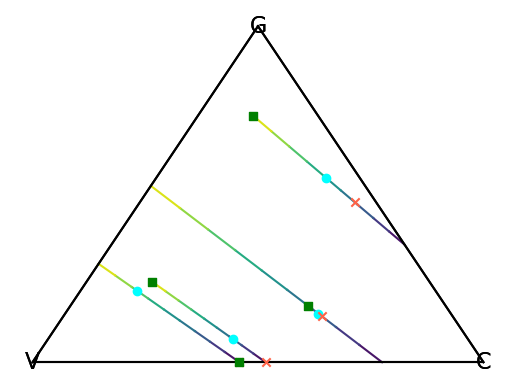

In [7]:
# the goal is to get the overall intensity as low as possible
Xhat3, Bhat3 = est.fit_underdetermined(B, underdetermined_opt='min')
# the goal is to get the overall intensity as close as possible to 0.1
Xhat3, Bhat3 = est.fit_underdetermined(B, underdetermined_opt=0.1)

### -- plotting --

# can compare the intensities found to our previous result by plotting both cases
from dreye.api.plotting.simplex_plot import plot_simplex

ax = None
# gradient line showing all possible solutions with the color indicating the overall intensity
for idx, X_ in enumerate(X):
    ax = plot_simplex(
        n=3, 
        gradient_line=X_, 
        ax=ax, lines=False, 
        gradient_line_kws={'add_colorbar': False, 'vmin': 0, 'zorder': 2}
    )

# with variance minization
ax = plot_simplex(
    n=3, 
    points=Xhat2, 
    point_scatter_kws={'marker': 'x', 'color': 'tomato', 'zorder': 2.6}, 
    labels=est.sources_labels, ax=ax
)
# standard approach - no variance minimization
ax = plot_simplex(
    n=3, 
    points=Xhat, 
    point_scatter_kws={'marker': 'o', 'color': 'cyan', 'zorder': 2.5}, 
    ax=ax, lines=False
)
# with an overall intensity objective
ax = plot_simplex(
    n=3, 
    points=Xhat3, 
    point_scatter_kws={'marker': 's', 'color': 'green', 'zorder': 2.6}, 
    labels=est.sources_labels, ax=ax
)